### 손글씨 숫자 데이터 분류

In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [ ]:
digits = load_digits()

X = digits.data
print(type(X))
print(X.shape)

y = digits.target
print(type(y))
print(y.shape)
print(y)

<class 'numpy.ndarray'>
(1797, 64)
<class 'numpy.ndarray'>
(1797,)
[0 1 2 ... 8 9 8]


### 학습과 테스트 데이터 분류

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

print('Type: x_train, y_train, x_test, y_test')
print(type(x_train), type(y_train), type(x_test), type(y_test))

print('Type: x_train, y_train, x_test, y_test')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Type: x_train, y_train, x_test, y_test
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Type: x_train, y_train, x_test, y_test
(1617, 64) (1617,) (180, 64) (180,)


### Tensor로 변환

In [ ]:
x_train = torch.tensor(x_train, dtype=torch.float).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.long).to('cuda')
x_test = torch.tensor(x_test, dtype=torch.float).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.long).to('cuda')

### Dataset을 만든다.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

print(train_dataset)
print(test_dataset)

### Dataloader를 만든다.
#### Overfit 유발시키는 코드

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10000, shuffle=True)  # 한번에 시험보려고(있는 만큼) -> 그래서 batch_size를 10000으로 설정

print(train_dataset)
print(test_dataset)

### 다층 nn.Linear를 이용한 모델

In [ ]:
k = 100

net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)

)

=> Overfit 유도를 위해서, network를 깊고, 복잡하고 크게 만들었다.<br>
   이런 경우, 학습데이터가 작기 때문에, 완전히 암기해버려서 overfit이 매우 잘 발생

### Loss함수: CrossEntropy

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

### 학습 시작

In [ ]:
train_losses = []
test_losses = []
net.to('cuda')

for epoc in range(100):

  batch_loss = 0.0
  net.train()

  for x_train, y_train in train_dataloader:
    
    optimizer.zero_grad()

    y_pred = net(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    batch_loss += loss.item()
  train_losses.append(batch_loss)
  print(epoc, 'Loss: ', batch_loss)

  # 학습 epoch마다, 테스트를 수행해서 loss 값을 계산
  net.eval()

  with torch.no_grad():
    for x_test, y_test in test_dataloader:
      test_result = net(x_test)
      test_loss = loss_fn(test_result, y_test)
      test_losses.append(test_loss.item())

0 Loss:  0.1649640363175422
1 Loss:  0.15505658117763232
2 Loss:  0.14704140328103676
3 Loss:  0.14147242551553063
4 Loss:  0.13970019266707823
5 Loss:  0.14326056715799496
6 Loss:  0.13506703253369778
7 Loss:  0.1419484012731118
8 Loss:  0.12702689255820587
9 Loss:  0.12934333743760362
10 Loss:  0.1213108102674596
11 Loss:  0.11596294106857385
12 Loss:  0.12260887524462305
13 Loss:  0.11368024576222524
14 Loss:  0.10953952390991617
15 Loss:  0.11706335179042071
16 Loss:  0.11129434514441527
17 Loss:  0.10503701743436977
18 Loss:  0.10394951191847213
19 Loss:  0.10151290543581126
20 Loss:  0.10377727981540374
21 Loss:  0.0943108131068584
22 Loss:  0.09423668529780116
23 Loss:  0.09236741216591327
24 Loss:  0.09199888829607517
25 Loss:  0.0880789234652184
26 Loss:  0.09339171009196434
27 Loss:  0.08814790334145073
28 Loss:  0.09122126636793837
29 Loss:  0.09290312062512385
30 Loss:  0.08276552876122878
31 Loss:  0.0828812156105414
32 Loss:  0.07877577572799055
33 Loss:  0.08120476728072

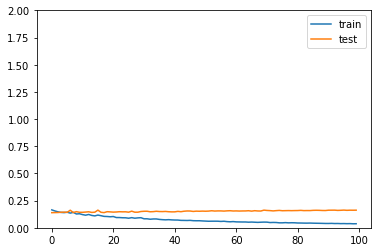

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend(loc='upper right')
plt.ylim((0, 2.0))
plt.show()

=> 학습데이터의 loss가 테스트보다 작다. 따라서, 학습 데이터에 최적화된 결과를 보여준다. overfit이 발생된 것이다.

### Dropout: overfit 해결
과학습을 방지하는 것을 정규화(regularization)이라고 한다.<br>
Dropout이라는 것이 자주 사용되는데, 입력의 일부분을 랜덤으로 사용하지 않는 방법이다.
<br><br>
Dropout을 하게 되면, 값을 지정된 확률 p에 따라 0으로 설정<br>
예를들어, (1.0, 1.0, 1.0)이라는 3차원 값이 있고, drop확률 p=0.5이면 각 값에 대해서 동전을 던져 앞면이 나오면 0으로 설정<br><br>
왜 살아남은 값들은 1/(1-p)를 곱해주는가?<br>
그 값들을 '강'하게 해서, 그 값들에 집중된 학습이 이루어지도록 함.

## Dropout 예제
### Input tensor 생성

In [ ]:
import torch
from torch import nn

input = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float)
print('Input: ', input)

Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Dropout 적용: 50%의 값을 0으로 설정

In [ ]:
m = nn.Dropout(p=0.5)
dropped_input = m(input)
print('Dropped: ', dropped_input)

# 꼭 0.5의 확률로 안될 수 있음!

Dropped:  tensor([2., 0., 0., 2., 2., 0., 2., 0., 0., 2.])


##### 주의할 점!
- dropout은 학습시킬 때만 사용하고 테스트할 때는, dropout없이 진행한다.

### 다층 nn.Linear를 이용한 모델

In [ ]:
k = 100
drop_prob = 0.1   # 입력값의 0.1은 zero로 만들고, 나머지는 10/9 곱해서 강하게 만들어준다.

net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(k, 10)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [ ]:
train_losses = []
test_losses = []
net.to('cuda')

for epoc in range(100):

  batch_loss = 0.0
  net.train()

  for x_train, y_train in train_dataloader:
    
    optimizer.zero_grad()

    y_pred = net(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    batch_loss += loss.item()
  train_losses.append(batch_loss)
  print(epoc, 'Loss: ', batch_loss)

  # 학습 epoch마다, 테스트를 수행해서 loss 값을 계산
  net.eval()

  with torch.no_grad():
    for x_test, y_test in test_dataloader:
      test_result = net(x_test)
      test_loss = loss_fn(test_result, y_test)
      test_losses.append(test_loss.item())

0 Loss:  1.2274721418507397
1 Loss:  1.4616676471196115
2 Loss:  1.2536605914356187
3 Loss:  1.3232005120953545
4 Loss:  1.2856447659432888
5 Loss:  1.0079174325801432
6 Loss:  1.0189665144425817
7 Loss:  0.8728343120310456
8 Loss:  1.1216764524579048
9 Loss:  1.0640793509082869
10 Loss:  0.816637855314184
11 Loss:  1.3077348491060548
12 Loss:  1.082398119266145
13 Loss:  1.1988074319742736
14 Loss:  1.1005054241977632
15 Loss:  1.6264408297138289
16 Loss:  1.3722684052190743
17 Loss:  0.7514042318216525
18 Loss:  0.9920904718455859
19 Loss:  1.0544778372277506
20 Loss:  0.9213335408712737
21 Loss:  1.3264856223831885
22 Loss:  0.9822904956527054
23 Loss:  1.0405261600972153
24 Loss:  0.9614466717466712
25 Loss:  1.5819905028911307
26 Loss:  1.0770256340038031
27 Loss:  1.0715905564429704
28 Loss:  0.764849406608846
29 Loss:  0.8783181300968863
30 Loss:  0.7610447377082892
31 Loss:  0.8902487781015225
32 Loss:  0.7392407862935215
33 Loss:  0.7799405862460844
34 Loss:  1.082266401062952

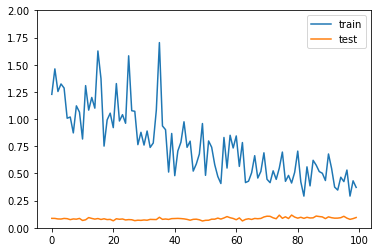

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend(loc='upper right')
plt.ylim((0, 2.0))
plt.show()

=> Dropout으로 인해서 학습 loss가 들쭉날쭉하다. 즉, 암기를 하지 않았다는 뜻이다. 실제 평가에 들어가면 우수한 성적을 낸다.